In [103]:
import numpy as np 
from scipy.special import gamma as gamma_function
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
#Fonction permettant d'échantilloner selon les lois
from numpy.random import dirichlet, normal, gamma
from scipy.stats import multivariate_normal as mult_norm, norm, invgamma, dirichlet as dirichlet_scipy

from functools import partial
from progressbar import ProgressBar
import time
%matplotlib inline

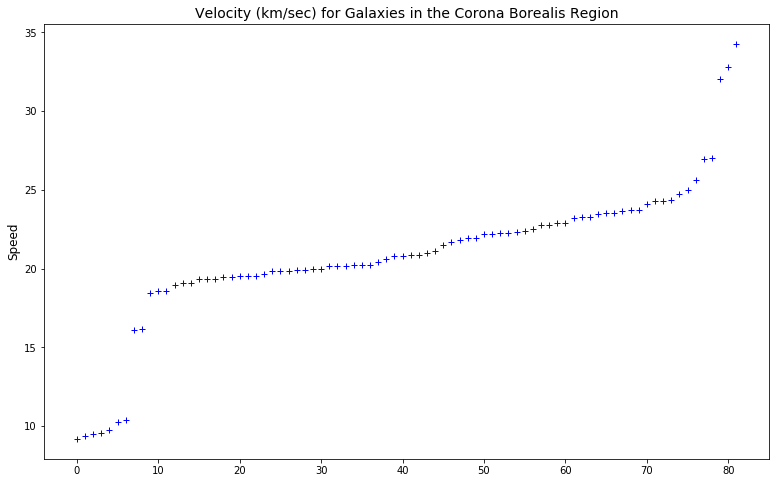

In [104]:
data = pd.read_csv('galaxy.csv', index_col=0)
y= data.iloc[:,0].values/1000
plt.figure(figsize=(13,8))
plt.plot(y,'b+', label="Velocity")
plt.title("Velocity (km/sec) for Galaxies in the Corona Borealis Region", fontsize=14)
plt.ylabel("Speed", fontsize=12)
plt.savefig('C:/Users/remib/Documents/ENSAE/3A/Statistiques bayesiennes/Bayesian_statistics_project/data.png')
plt.show()

### Le but de cette étude est de trouver le nombre de clusters définissant la distribution des vitesses des étoiles dans la région de la [couronne boréale](https://fr.wikipedia.org/wiki/Couronne_bor%C3%A9ale)

Cet article propose d'estimer la distribution marginale $p(y)$ de la vraisemblance $L(y ;\theta)$. Pour celà, des estimateurs basés sur des échantillons obtenus par un échantilloneur de Gibbs sont utilisés. 
Dans notre exemple, on suppose que les données sont distribuées selon un modèle de mélange avec k groupes. Le modèle est défini comme suit. 
Priors du modèle
$$
\mu_j \sim \mathcal{N}(\mu_0 , phi)\\
\sigma_j \sim \mathcal{IG}(\frac{v_0}{2}, \frac{\delta_0}{2})\\
q \sim Dirichlet(\alpha_1, ..., \alpha_d)
$$
où d = nombre de clusters considérés (2 ou 3)

$\mu_0 = 20, \ A^{-1} = 100, \ v_0 = 6, \ \delta_0 = 40,\ \alpha_j = 1$

In [105]:
def normal_update(n_clust, clust_mean, sigma, sigma0=100,mu0=20,v0=6, delta0=40):   
    ### Mean & var posterior de mu
    mu_mean_up = np.divide(n_clust*clust_mean* sigma0 + mu0 * sigma , sigma0 *n_clust + sigma )
    mu_var_up = np.divide(sigma0  * sigma, sigma0 * n_clust + sigma)

    return mu_mean_up, mu_var_up

def dirichlet_update(n_clust,alpha0=1):
    return alpha0 + n_clust

def InvGamma_update(n_clust, delta, v0=6, delta0= 40):
    ### Paramètre de la loi posterieure de sigma
    v_up = v0 +n_clust
    delta_up = delta + delta0
    return v_up, delta_up

def z_update(q, mu, sigma, y, nb_clust=3):
    #retourne les probabilités q[j] d'être dans le cluster j
    return np.array([ np.exp( np.log(q[i]) + mult_norm.logpdf(x=y,mean=mu[i],cov=sigma[i])) for i in range(nb_clust)]).T
                  
    #return np.array([q[i]*mult_norm.pdf(x=y,mean=mu[i],cov=sigma[i]) for i in range(nb_clust)]).T


In [106]:
## Initialisation des paramètres
nb_clust = 2
n_iter = 6000
burn_in = 1000

mu0= 20
v0 = 6
delta0 = 40
alpha0 = np.ones(nb_clust)
sigma0 = 100

### Progression de l'algorithme
bar = ProgressBar(maxval=n_iter)
bar.start()


n_clust = np.zeros((n_iter,nb_clust))

delta,clust_mean= np.zeros( (n_iter, nb_clust)),np.zeros( (n_iter, nb_clust))
mu_sample, sigma_sample=np.zeros( (n_iter, nb_clust)), np.zeros( (n_iter, nb_clust))
z_sample= np.random.randint(0,nb_clust,size=(1,y.shape[0]))
q_up = np.ones( (n_iter,nb_clust))

for i in range(2,n_iter):
    #Calcul des quantités nécessaires pour la mise à jour des paramètres : moyenne intra clust et mse intra clust
    n_clust[i] = np.array([(z_sample[-1]==k).sum() for k in range(nb_clust)])
    for k in range(nb_clust):
        if (n_clust[i,k]==0):
            continue
        else:
            delta[i,k] = np.sum(np.square(y[z_sample[-1]==k]-mu_sample[i-1][k]))
            clust_mean[i,k] = np.mean(y[z_sample[-1]==k])
    
    #Mise à jour de la variance sigma
    sigma_sample[i] = np.divide(1,gamma((v0 + n_clust[i])/2, scale= 2/(delta0 + delta[i])))
    
    #Mise à jour de la moyenne mu
    mu_mean_up, mu_var_up = normal_update(n_clust[i], clust_mean[i], sigma=sigma_sample[i], sigma0=sigma0)
    mu_sample[i] = normal(loc = mu_mean_up, scale = np.sqrt(mu_var_up))
    

    ### Mise à jour de la proba q
    q_up[i] = dirichlet(alpha0+n_clust[i-1])
    
    #Mise à jour des probas de chaque cluster
    w = z_update(q_up[i], mu_sample[i], sigma_sample[i],y, nb_clust=nb_clust)       
    w = np.divide(w,w.sum(axis=1, keepdims=True))
    z_sample = np.vstack((z_sample,np.array([np.random.choice(range(nb_clust), p=w[ii]) for ii in range(y.shape[0])])))
    bar.update(i)
bar.finish()

100% (6000 of 6000) |####################| Elapsed Time: 0:00:43 Time:  0:00:43


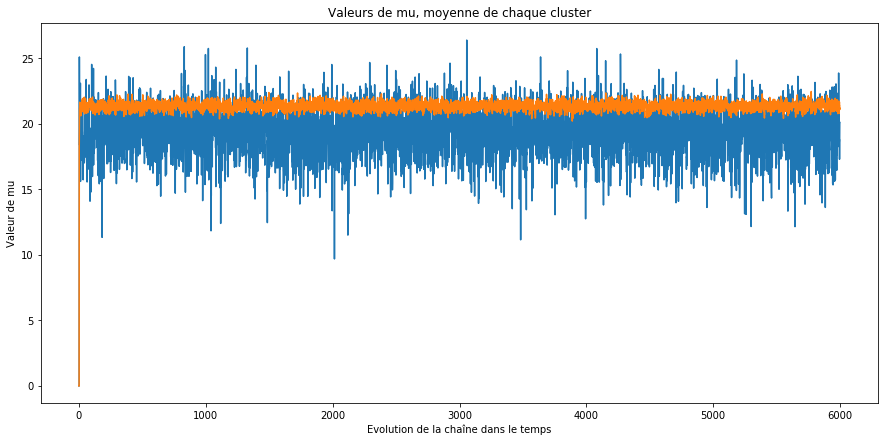

In [107]:
fig,ax = plt.subplots(1,figsize=(15,7))

ax.plot(mu_sample, label="mu")
ax.set_xlabel('Evolution de la chaîne dans le temps')
ax.set_ylabel('Valeur de mu')

plt.title('Valeurs de mu, moyenne de chaque cluster')
plt.savefig('Evolution_des_moyennes_des_clusters_k_2.png')
plt.show()

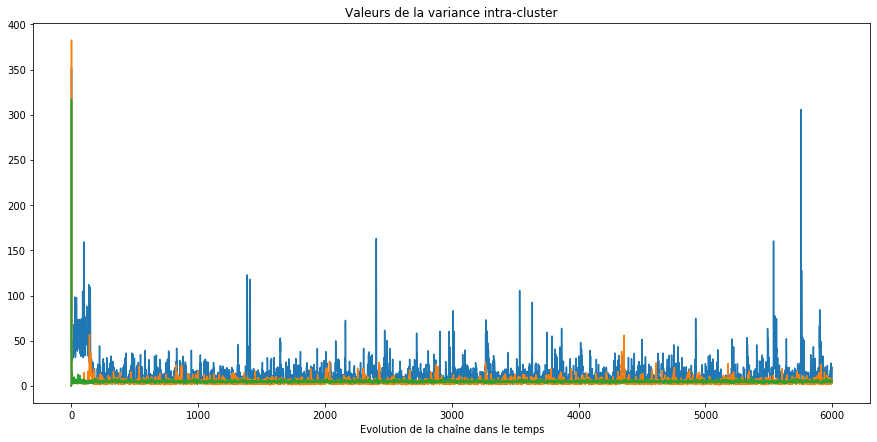

In [6]:
plt.figure(figsize=(15,7))
plt.plot(sigma_sample)
plt.title("Valeurs de la variance intra-cluster")
plt.xlabel("Evolution de la chaîne dans le temps")
plt.show()

### Calcul du premier bloc : 

$$
    \text{Estimator} = \log( L( \mu^*, \sigma^*, q^*; y)) + \log( \pi( \mu^*, \sigma^*, q^* )) - \pi( \mu^* \mid y)
$$

In [7]:
def Log_likelihood(q, mu, sigma):
    '''
    Prend un seul y, calcul la densité pour chaque cluster et pondère par la proba du cluster
    #INPUT : q = dimension 3, proba de chaque cluster
    #       mu = dimension 3, moyenne de chaque cluster
    #    sigma = dimension 3, var de chaque cluster
    '''
    return np.log(list(map(lambda i: np.exp(np.log(q)+np.log(list(map(norm.pdf,y[i]*np.ones(3), mu, np.sqrt(sigma))))).sum(), range(y.shape[0])))).sum()

def Log_likelihood_wrapper(i):
    return Log_likelihood(q=q_up[i], mu=mu_sample[i], sigma =sigma_sample[i])

#On utilise le maximum de vraisemblance, même si ce n'est pas nécessaire,
#celà permet des calculs plus stable, c.f article

likelihood_chain =  np.array(list(map(Log_likelihood_wrapper,range(burn_in, n_iter) )))
t = np.argmax(likelihood_chain ) + burn_in




### Meilleure vraisemblance de nos données 
print('Valeur de la log vraisemblance max %f :' %Log_likelihood_wrapper(t))

mu_star, sigma_star, q_star = mu_sample[t], sigma_sample[t], q_up[t]

Valeur de la log vraisemblance max -209.679489 :


In [8]:
def log_prior(mu,sigma,q):
    
    #Les paramètres sont à priori indépendants donc :
    result = dirichlet_scipy.logpdf(q,alpha=alpha0)+ \
    np.sum(norm.logpdf(mu, loc=mu0, scale=np.sqrt(sigma0) )) + \
    np.sum( (v0/2)*np.log(delta0/2) - np.log(gamma_function(v0/2)) - ( (v0/2) + 1)*np.log(sigma)- (delta0/(2*sigma))  )
    
    return result

print('Valeurs du prior en theta* : %f' %log_prior(mu_star,sigma_star,q_star))

estimator_first_step = Log_likelihood_wrapper(t) + log_prior(mu_star,sigma_star,q_star)

Valeurs du prior en theta* : -21.364065


In [9]:
def posterior_mu(mu,sigma,z):
    n_clust, clust_mean = [],[]
    for i in range(nb_clust):
        n_clust.append( (z==i).sum()) 
        clust_mean.append(np.mean(y[z==i]))
    n_clust, clust_mean= np.nan_to_num(n_clust), np.nan_to_num(clust_mean)

    return np.exp(np.sum( norm.pdf(x=mu,loc= np.divide(n_clust*clust_mean *sigma0 + mu0*sigma,n_clust*sigma0 + sigma), 
                               scale=np.sqrt(np.divide(sigma0*sigma,n_clust* sigma0 + sigma)))))

def posterior_mu_wrapper(i):
    return posterior_mu(mu_star, sigma_sample[i],z_sample[i])

pi_mu_post = np.array(list(map(posterior_mu_wrapper, range(burn_in, n_iter-1))))
log_post_estimate_mu = np.log(np.mean(pi_mu_post))

print('Valeur du log posterior en mu* conditionnellent à y: %f' %log_post_estimate_mu)


Valeur du log posterior en mu* conditionnellent à y: 2.076435


### Deuxième partie 
Estimation de :
$
\pi( \sigma^* \mid \mu^* , y ) 
$

In [10]:
#Initialisation
n_clust = np.zeros((n_iter,nb_clust))
delta,clust_mean= np.zeros( (n_iter, nb_clust)),np.zeros( (n_iter, nb_clust))
mu_sample, sigma_sample=np.zeros( (n_iter, nb_clust)), np.zeros( (n_iter, nb_clust))
z_sample= np.random.randint(0,nb_clust,size=(1,y.shape[0]))
q_up = np.ones( (n_iter,nb_clust))

bar = ProgressBar(maxval=n_iter)
bar.start()
for i in range(2,n_iter):
    for k in range(nb_clust):
        n_clust[i,k]= (z_sample[-1]==k).sum()
        if (n_clust[i,k]==0):
            continue
        else:
            delta[i,k] = np.sum(np.square(y[z_sample[-1]==k]-mu_star[k]))
    
    #Mise à jour des probas q
    sigma_sample[i] = np.divide(1,gamma((v0 + n_clust[i])/2, scale= 2/(delta0 + delta[i])))
    ### Mise à jour de la proba q
    q_up[i] = dirichlet(alpha0+n_clust[i])
    
    #Mise à jour des probas de chaque cluster
    w = z_update(q_up[i], mu_star, sigma_sample[i],y, nb_clust=nb_clust)       
    #w = np.nan_to_num(w)
    w = np.divide(w,w.sum(axis=1, keepdims=True))
    z_sample = np.vstack((z_sample,np.array([np.random.choice(range(nb_clust), p=w[ii]) for ii in range(y.shape[0])])))
    bar.update(i)
bar.finish()
    
    

100% (6000 of 6000) |####################| Elapsed Time: 0:00:45 Time:  0:00:45


#### Calcul de l'estimateur suivant la méthode du papier 

In [11]:
def log_post_sigma(mu,sigma, z):
    n_clust = np.array([(z_sample[-1]==k).sum() for k in range(nb_clust)])
    delta = np.array([np.sum(np.square(y[z_sample[-1]==k]-mu[k])) for k in range(nb_clust)])
    return np.exp(np.sum(invgamma.logpdf(sigma, a=(v0 + n_clust)/2 , scale= (delta0+delta)/2 )))

def log_post_sigma_wrapper(i):
    return log_post_sigma(mu_star, sigma_star, z_sample[i])

pi_sigma_post = np.array(list(map(log_post_sigma_wrapper, range(burn_in, n_iter-1))))
log_post_estimate_sigma = np.log(np.mean(pi_sigma_post))

In [12]:
print('Valeur du log posterior de sigma sachant z, mu* : %f' %log_post_estimate_sigma)

Valeur du log posterior de sigma sachant z, mu* : -6.673861


### Calcul de l'estimateur 3 suivant la méthode du papier

In [13]:
#Initialisation
n_clust = np.zeros((n_iter,nb_clust))
mu_sample =np.zeros( (n_iter, nb_clust))
q_up = np.ones( (n_iter,nb_clust))


bar = ProgressBar(maxval=n_iter)
bar.start()
for i in range(n_iter):
    n_clust[i] = np.array([(z_sample[-1]==k).sum() for k in range(nb_clust)])

    #Mise à jour des probas q
    q_up[i] = dirichlet(alpha0+n_clust[i])
    
    #Mise à jour de z
    w = z_update(q_up[i], mu_star, sigma_star,y,nb_clust=nb_clust)
    w = np.nan_to_num(w)
    w = np.divide(w,w.sum(axis=1, keepdims=True))
    z_sample = np.vstack((z_sample,np.array([np.random.choice(range(nb_clust), p=w[l]) for l in range(y.shape[0])])))
    bar.update(i)
bar.finish()
    
    

100% (6000 of 6000) |####################| Elapsed Time: 0:01:05 Time:  0:01:05


In [14]:
### Calculer de la dernière log densité postérieur conditionnelle aux autre paramètre

def log_post_q(z):
    n_clust = np.array([(z==k).sum() for k in range(nb_clust)])
    return dirichlet_scipy.logpdf(q_star, alpha=alpha0 + n_clust)
def log_post_q_wrapper(i):
    return log_post_q(z_sample[i])

pi_q_post = np.array(list(map(log_post_q_wrapper,range(burn_in, n_iter-1))))
log_post_estimate_q = np.log(np.mean(pi_q_post))
print('Valeur du log posterior de q sachant z, mu* , sigma*: %f' %log_post_estimate_q)

Valeur du log posterior de q sachant z, mu* , sigma*: 1.601628


In [15]:
marginal_likelihood_estimator = estimator_first_step - log_post_estimate_mu - log_post_estimate_sigma - log_post_estimate_q
print("L'estimateur de la vraisemblance marginale est vaut %f :" %marginal_likelihood_estimator)

L'estimateur de la vraisemblance marginale est vaut -228.047757 :


In [98]:
### Estimation de la variance, par la délta méthode

In [99]:
### Renvoie le vecteur utile pour le calcul de la variance
def omega(mu_chain,sigma_chain,q_chain, mu_hat, sigma_hat, q_hat):
    h = np.vstack((mu_chain,sigma_chain,q_chain))
    h_hat = np.vstack((mu_hat,\
                       sigma_hat,\
                       q_hat))
    return h - h_hat

h_test  = omega(mu_chain = pi_mu_post,\
      sigma_chain= pi_sigma_post,\
      q_chain = pi_q_post,\
      mu_hat = log_post_estimate_mu,\
      sigma_hat = log_post_estimate_sigma,\
      q_hat = log_post_estimate_q) 

In [100]:
q=10
G = 4999

var = np.dot(h_test[:,0].reshape(3,1),h_test[:,0].reshape(3,1).T)
var /= G
for s in range(1,q):
    omega_s= 0
    for g in range(s+1,G):
        omega_s += np.dot(h_test[:,g].reshape(3,1),h_test[:,g].reshape(3,1).T)
    omega_s /= G
    var += (1 - (s/(q+1)))*(omega_s + omega_s.T)
var = var/G
jacobian_hat = np.array([1/log_post_estimate_mu,1/log_post_estimate_sigma,1/log_post_estimate_q]).reshape(3,1)
var_chib_est = np.dot(np.dot(jacobian_hat.T, var ),jacobian_hat)
print('La variance de notre estimateur est de %f' %var_chib_est[0])

La variance de notre estimateur est de 0.032998


In [102]:
np.sqrt(var_chib_est)

array([[0.1816531]])